## Sentiment Analysis

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

In [77]:
import numpy as np
import pandas as pd

reviews = pd.read_csv('reviews.txt', header=None)
labels = pd.read_csv('labels.txt', header=None)
Y = (labels=='positive').astype(np.int_)

print(type(reviews))
print(reviews.head())

<class 'pandas.core.frame.DataFrame'>
                                                   0
0  bromwell high is a cartoon comedy . it ran at ...
1  story of a man who has unnatural feelings for ...
2  homelessness  or houselessness as george carli...
3  airport    starts as a brand new luxury    pla...
4  brilliant over  acting by lesley ann warren . ...


**(a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing. Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

reviews = pd.read_csv('reviews.txt', header=None)
labels = pd.read_csv('labels.txt', header=None)

Y = (labels[0] == 'positive').astype(np.int_)

X_train, X_temp, Y_train, Y_temp = train_test_split(reviews[0], Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

vectorizer = CountVectorizer(max_features=10000)
X_train_bow = vectorizer.fit_transform(X_train).toarray()
X_val_bow = vectorizer.transform(X_val)
X_test_bow = vectorizer.transform(X_test)

print("Training set shape:", X_train_bow.shape, Y_train.shape)
print("Validation set shape:", X_val_bow.shape, Y_val.shape)
print("Test set shape:", X_test_bow.shape, Y_test.shape)

#Amount of samples, feature vector of length 10.000, corresponding lebels for the samples

Training set shape: (17500, 10000) (17500,)
Validation set shape: (3750, 10000) (3750,)
Test set shape: (3750, 10000) (3750,)


**(b)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

The most frequent words are represented with a unique index going from 0 to max_features which is 10.000 by the CountVectorizer

{
    'the': 0,
    'and': 1,
    'is': 2,
    'a': 3,
    'to': 4,
    ...
}

A whole review solely focus on frequency of each word corresponding to the position of first array, and does not preserve the exact position of each word

If we have the sentence:

The is to the and = [2,1,1,0,1,0,0,0,0,0......]

This will lead lead to a lot of zeros (9996 to be exact) since they also contain a count for all the other words not represented

Since most reviews will not contain all 10,000 words, the resulting matrix is typically sparse, Libraries like scipy are often used to efficiently store and manipulate these sparse matrices.

**(c)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

Recommended hypertuning for neural network according to Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow.pdf 3rd edition

Table 11-3. Default DNN configuration

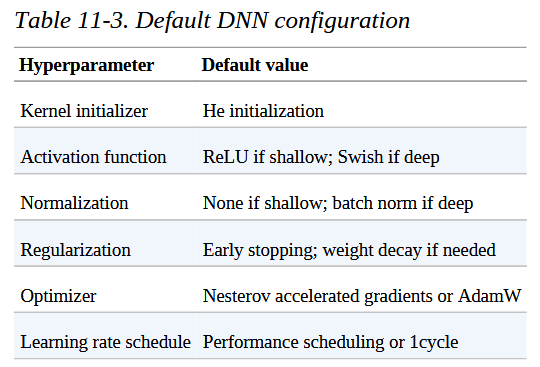

Table 11-4. DNN configuration for a self-normalizing net

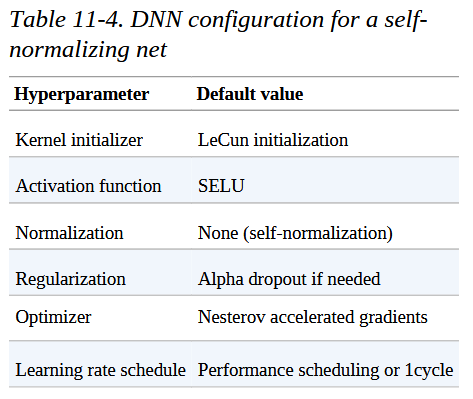


Don’t forget to normalize the input features!

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from kerastuner import HyperModel, RandomSearch
from tensorflow.keras import regularizers

# Define the hypermodel, for tuner options
class MyHyperModel(HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Input(shape=(X_train_bow.shape[1],)))
        
        kernel_initializer = hp.Choice('kernel_initializer', 
                                        values=['he_normal', 'lecun_normal'])
        
        activation_function = hp.Choice('activation_function', 
                                         values=['relu', 'selu', 'swish'])
        
        l2_regularization = hp.Choice('l2_regularization', 
                                values=[0.0, 0.001, 0.01])
        model.add(layers.Dense(hp.Int('units', min_value=32, max_value=256, step=32), 
                               activation=activation_function, 
                               kernel_initializer=kernel_initializer,
                               kernel_regularizer=regularizers.l2(l2_regularization)))
        
        model.add(layers.Dense(1, activation='sigmoid'))
        
        optimizer = hp.Choice('optimizer', 
                               values=['sgd', 'adamw'])
        
        model.compile(optimizer=optimizer, 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])
        
        return model

tuner = RandomSearch(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=1,
    directory='my_dir',
    project_name='hyperparameter_tuning'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

tuner.search(X_train_bow, Y_train, 
             epochs=50, 
             validation_data=(X_val_bow, Y_val), 
             callbacks=[early_stopping, reduce_lr])

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = tuner.get_best_models(num_models=1)[0]

initial_val_loss, initial_val_accuracy = best_model.evaluate(X_val_bow, Y_val)
print(f'Best Validation Accuracy: {initial_val_accuracy:.4f}')

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f"Kernel initializer: {best_hyperparameters.get('kernel_initializer')}")
print(f"Activation function: {best_hyperparameters.get('activation_function')}")
print(f"Units per layer: {best_hyperparameters.get('units')}")
print(f"Optimizer: {best_hyperparameters.get('optimizer')}")


Reloading Tuner from my_dir/hyperparameter_tuning/tuner0.json


/home/jonas/myenv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8973 - loss: 0.2715
Best Validation Accuracy: 0.8944
Best Hyperparameters:
Kernel initializer: he_normal
Activation function: swish
Units per layer: 224
Optimizer: adamw


**(d)** Test your sentiment-classifier on the test set.

In [ ]:
# Test set results based on the best found hyperparameters
test_loss, test_accuracy = best_model.evaluate(X_test_bow, Y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8884 - loss: 0.2879
Test Loss: 0.2687
Test Accuracy: 0.8944


**(e)** Use the classifier to classify a few sentences you write yourselves. 

In [ ]:
new_sentences = [
    #Easy sentences
    "I absolutely loved this product! It works great.",
    "This is the worst experience I've ever had.",
    "It's okay, not the best but not the worst either.",
    "I would definitely recommend this to my friends.",
    #Hard sentences
    "The juxtaposition of the vibrant colors in the painting elicited a profound sense of awe.",
    "Despite the cacophony of the bustling city, I found solace in the quaint little café.",
    "Her perspicacious observations during the discussion illuminated the complexities of the topic.",
    "The novel's intricate narrative structure challenged my comprehension but ultimately rewarded my perseverance.",
    "His obfuscation of the facts only served to exacerbate the already tenuous situation.",
    "I can't decide if the movie was brilliant or just confusing.",
    "The food was neither exceptional nor terrible; it was just average.",
    "I felt a strange mix of emotions after reading the book; it left me contemplative.",
    "The presentation was informative, but I wasn't sure if it was engaging enough.",
    "While the service was prompt, the atmosphere felt somewhat sterile."
]

new_sentences_bow = vectorizer.transform(new_sentences).toarray()

predictions = best_model.predict(new_sentences_bow)

predicted_labels = ['positive' if pred > 0.5 else 'negative' for pred in predictions]

for sentence, label in zip(new_sentences, predicted_labels):
    print(f'Sentence: "{sentence}" => Predicted label: {label}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Sentence: "I absolutely loved this product! It works great." => Predicted label: positive
Sentence: "This is the worst experience I've ever had." => Predicted label: negative
Sentence: "It's okay, not the best but not the worst either." => Predicted label: negative
Sentence: "I would definitely recommend this to my friends." => Predicted label: positive
Sentence: "The juxtaposition of the vibrant colors in the painting elicited a profound sense of awe." => Predicted label: positive
Sentence: "Despite the cacophony of the bustling city, I found solace in the quaint little café." => Predicted label: negative
Sentence: "Her perspicacious observations during the discussion illuminated the complexities of the topic." => Predicted label: positive
Sentence: "The novel's intricate narrative structure challenged my comprehension but ultimately rewarded my perseverance." => Predicted label: positive
Sentence: "His obfuscation of the facts only served to exac